### Mục tiêu của tập dữ liệu là khám phá khả năng cho các mô hình NLP phân loại các câu trong phần tóm tắt của văn bản y tế 

In [154]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX330 (UUID: GPU-20f71d64-3d10-0c42-a679-ce509a00e17e)


In [155]:
#Project này sử dụng file chứa 20.000 bản tóm tắt
data_dir = "D:/Github/Sequenctial-Sentence-Classification-in-Medical-Abstracts/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [156]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['D:/Github/Sequenctial-Sentence-Classification-in-Medical-Abstracts/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'D:/Github/Sequenctial-Sentence-Classification-in-Medical-Abstracts/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'D:/Github/Sequenctial-Sentence-Classification-in-Medical-Abstracts/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [157]:
# Đọc từng dòng trong file 
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [158]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [159]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.
  Trả về list chứa dictionary: 

      [{"target": 'CONCLUSION', 
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}] 
        
        target: label của text 
        text: câu cần phân loại 
        line_number: vị trí dòng text trong văn bản tóm tắt. 
        total_lines: số lượng câu trong 1 văn bản tóm tắt (tính từ ### đến ### liền sau đó )
  """
  input_lines = get_lines(filename) 
  abstract_lines = "" # Tạo 1 bản tóm tắt rỗng
  abstract_samples = [] # Tạo list chứa các dictionary 
  
  # Lặp lại từng dòng trong file 
  for line in input_lines:
    if line.startswith("###"): # Kiểm tra dòng ID: Ví dụ ###24491034 
      abstract_id = line
      abstract_lines = "" # reset lại abstract_lines
        
    elif line.isspace(): # Kiểm tra nếu là 1 dòng trống 
      abstract_line_split = abstract_lines.splitlines() # Chia phần văn bản thành các dòng riêng biệt 

      # Lặp lại từng dòng trong văn bản và lưu thứ tự, xét trong từng văn bản tóm tắt (VD từ ###24491034 -> ###24491035)
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Tạo 1 dictionary 
        target_text_split = abstract_line.split("\t") # Tách label khỏi test
        line_data["target"] = target_text_split[0] # Lưu label vào "target"
        line_data["text"] = target_text_split[1].lower() # Lưu text vào "text"
        line_data["line_number"] = abstract_line_number # Lưu thứ tự câu vào "line_number"
        line_data["total_lines"] = len(abstract_line_split) - 1 # Số lượng câu trong text
        abstract_samples.append(line_data) # Thêm dictionary vào list abstract_samples 
    
    else: # Nếu không phải dòng trống -> thêm dòng vào abstract_lines
      abstract_lines += line
  
  return abstract_samples

In [160]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: total: 797 ms
Wall time: 919 ms


(180040, 30212, 30135)

In [161]:
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

In [162]:
# Đưa data về dạng bảng 
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


In [163]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Khảo sát dữ liệu 

In [164]:
# Kiểm tra số lượng của từng label trong tập train 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

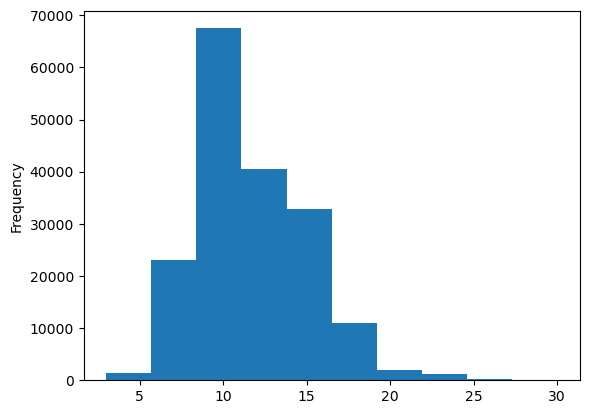

In [165]:
# Phân phối độ dài từng văn bản tóm tắt 
train_df.total_lines.plot.hist(); # -> hầu hết văn bản có độ dài từ 7 -> 15 dòng 

In [166]:
# Chuyển đổi file text thành list để làm đầu vào cho mô hình 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [167]:
# Tạo nhãn số - Mô hình ML đòi hỏi nhãn số 
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [168]:
# Mã hóa nhãn 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [169]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Tạo mô hình

### Model_0: TF-IDF Multinomial Naive Bayes

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Khởi tạo 1 pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])


model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [171]:
# Đo độ chính xác bằng score 
print("Tập train: " + str(model_0.score(X = train_sentences,y = train_labels_encoded)))
print("Tập test: " + str(model_0.score(X = test_sentences,y = test_labels_encoded)))
print("Tập val: " + str(model_0.score(X = val_sentences,y = val_labels_encoded)))

Tập train: 0.7516829593423684
Tập test: 0.716674962667994
Tập val: 0.7218323844829869


In [172]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_results(y_true, y_pred):
    dict_score = {}
    dict_score["Precision"] = precision_score(y_true = y_true, y_pred = y_pred, average='weighted')*100
    dict_score["F1_score"] = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')*100
    dict_score["Recall_score"] = recall_score(y_true = y_true, y_pred = y_pred, average='weighted')*100
    dict_score["Accuracy_score"] = accuracy_score(y_true = y_true, y_pred = y_pred)*100
    return dict_score

In [173]:
baseline_results = calculate_results(model_0.predict(test_sentences), test_labels_encoded) 
baseline_results

{'Precision': 78.15975318595406,
 'F1_score': 74.08397549503034,
 'Recall_score': 71.6674962667994,
 'Accuracy_score': 71.6674962667994}

### Tiền xử lý dữ liệu cho mô hình DL

In [174]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [175]:
# Chuyển đổi các câu thành số -> cần tìm số từ có trong mỗi câu 
# Mô hình hoạt động tốt khi các câu có cùng độ dài 
# Các câu ngắn hơn sau khi chuyển qua số -> thêm các số 0 để có cùng độ dài với các câu dài hơn 

# Tìm độ dài trung bình của mỗi câu 
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.338269273494777

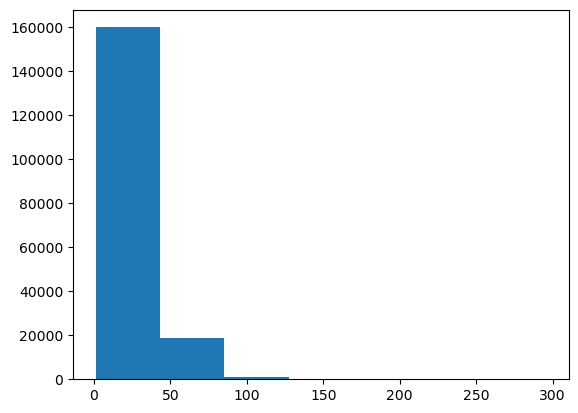

In [176]:
# Trực quan 
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7); # => độ dài trung bình từ 0 -> 50 ( Trong hình )

In [177]:
output_seq_len = int(np.percentile(sent_lens, 95)) # sử dụng percentile để tìm số lượng chiếm 95%
output_seq_len 
# => 0 -> 55 chiếm ~ 95%

# Chọn 54 làm quy chuẩn, các câu ngắn hơn 54 sẽ được thêm vào, các câu dài hơn 55 thì các từ từ 56 trở đi bị cắt 

55

In [178]:
# Tạo text vectorizer

max_tokens = 68000 # Bài báo nêu kích thước từ vựng là 68000

In [179]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [180]:
text_vectorizer.adapt(train_sentences)

In [181]:
# Số lượng từ vựng trong tập train
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [182]:
# cofig của text vectoriver 
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [183]:
# Tạo token embedding layer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # Độ dài của vocabulary
                               output_dim=128, 
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Text:
between june @ and june @ , @ patients with cervical vertebrae fractures or dislocation were treated with modified skull traction surgery ( trial group , n = @ ) and traditional skull traction surgery ( control group , n = @ ) .

Length of text: 44

Vectorized text:
[[   30  1367     3  1367    12     7   883 11784  1285    16  8730     9
    172     7   599  8363  4458   115    32    13    40     3   803  8363
   4458   115    35    13    40     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence before vectorization:
between june @ and june @ , @ patients with cervical vertebrae fractures or dislocation were treated with modified skull traction surgery ( trial group , n = @ ) and traditional skull traction surgery ( control group , n = @ ) .

Sentence after vectorization (before embedding):
[[   30  1367     3  1367    12     7   883 11784  1285    16  8730     9
 

In [184]:
# tf.data: tải dữ liệu nhanh hơn 

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [185]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model_1 Conv1D with token embeddings

In [186]:
# Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
# Build model -> Train model -> Evaluate model

# Tạo mô hình 1D convolutional để xử lý trình tự 

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) 
token_embeddings = token_embed(text_vectors) # Khởi tạo embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 5)                 325 

In [187]:
# Fit mô hình 
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) 

Epoch 1/3
562/562 [==============================] - 53s 93ms/step - loss: 0.9195 - accuracy: 0.6385 - val_loss: 0.6880 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 58s 102ms/step - loss: 0.6568 - accuracy: 0.7581 - val_loss: 0.6306 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 57s 102ms/step - loss: 0.6148 - accuracy: 0.7745 - val_loss: 0.5952 - val_accuracy: 0.7839


In [188]:
model_1.evaluate(valid_dataset)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

945/945 [==============================] - 3s 3ms/step


{'Precision': 78.34275554974171,
 'F1_score': 78.41207063730432,
 'Recall_score': 78.66079703429101,
 'Accuracy_score': 78.66079703429101}

### Model 2: Conv1D with character embeddings 

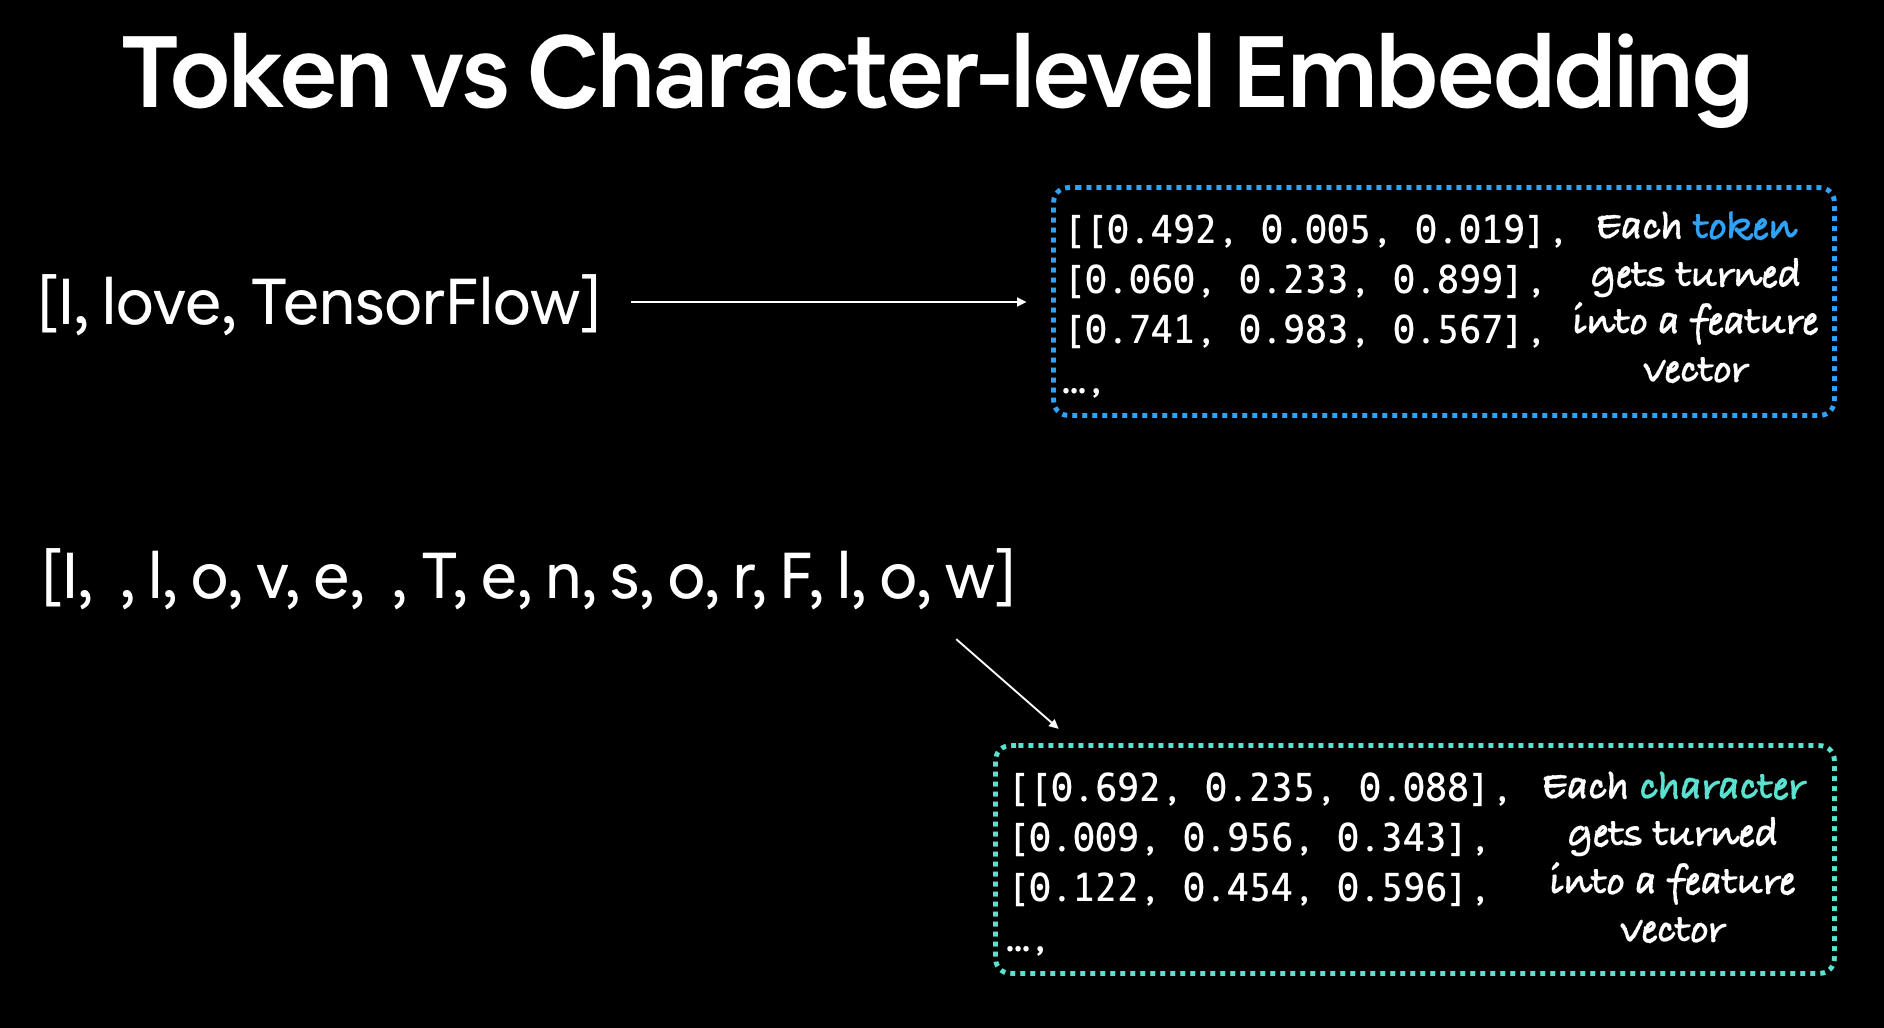

In [189]:
# Chia thành từng kí tự 
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [190]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

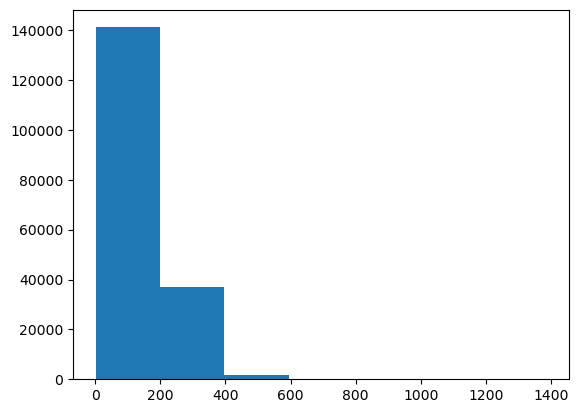

In [191]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [192]:
# Độ dài số lượng chữ cái chiếm 95% dữ liệu bằng percentile 
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len 

290

In [193]:
# Số lượng ký tự khác nhau 
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)
print("Số lượng ký tự bàn phím: " + str(len(alphabet)))

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Số lượng ký tự bàn phím: 68


In [194]:
# Tạo char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")


char_vectorizer.adapt(train_chars)

In [195]:
# Khởi tạo char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # Số lượng ký tự khác nhau 
                              output_dim=25, 
                              mask_zero=False, 
                              name="char_embed")


inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_conv1D_char_embedding")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 5

In [196]:
# Create char datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [197]:
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 28ms/step - loss: 1.2674 - accuracy: 0.4845 - val_loss: 1.0333 - val_accuracy: 0.5938
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.9984 - accuracy: 0.6054 - val_loss: 0.9301 - val_accuracy: 0.6363
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.9302 - accuracy: 0.6361 - val_loss: 0.8639 - val_accuracy: 0.6669


In [198]:
model_2.evaluate(val_char_dataset)

model_2_pred_probs = model_2.predict(val_char_dataset)

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_preds)
model_2_results

945/945 [==============================] - 5s 5ms/step


{'Precision': 64.49505472226515,
 'F1_score': 64.59480944086269,
 'Recall_score': 65.74539917913413,
 'Accuracy_score': 65.74539917913413}

### Model 3: Feature extraction with pretrained token embeddings

In [199]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [200]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_3 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [201]:
# Fit feature extractor model for 3 epochs
model_3.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 14ms/step - loss: 0.9156 - accuracy: 0.6497 - val_loss: 0.7966 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7686 - accuracy: 0.7015 - val_loss: 0.7547 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7522 - accuracy: 0.7115 - val_loss: 0.7405 - val_accuracy: 0.7098


In [202]:
model_3_pred_probs = model_3.predict(valid_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Calculate results from TF Hub pretrained embeddings results on validation set
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

945/945 [==============================] - 10s 9ms/step


{'Precision': 71.4912969424484,
 'F1_score': 71.17960029693675,
 'Recall_score': 71.43850125777837,
 'Accuracy_score': 71.43850125777837}

### Model 4: Kết hợp token embeddings + character embeddings (hybrid embedding layer)

In [203]:
# 1. Thiết lập token inputs/model 
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Thiết lập char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Kết nối token and char inputs (Khởi tạo hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Khởi tạo output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Xây dựng model 
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [204]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [205]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [206]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [208]:
#Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 170s 295ms/step - loss: 0.9690 - accuracy: 0.6119 - val_loss: 0.7820 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 154s 274ms/step - loss: 0.7928 - accuracy: 0.6956 - val_loss: 0.7159 - val_accuracy: 0.7217
Epoch 3/3
562/562 [==============================] - 171s 304ms/step - loss: 0.7688 - accuracy: 0.7045 - val_loss: 0.6897 - val_accuracy: 0.7327


In [209]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)

# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 68s 69ms/step


{'Precision': 73.33724707747793,
 'F1_score': 73.06257010430775,
 'Recall_score': 73.33509863630346,
 'Accuracy_score': 73.33509863630346}

### Model 5: Token embeddings + Character Embeddings + Positional embeddings

#### Khởi tạo Positional embeddings 

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

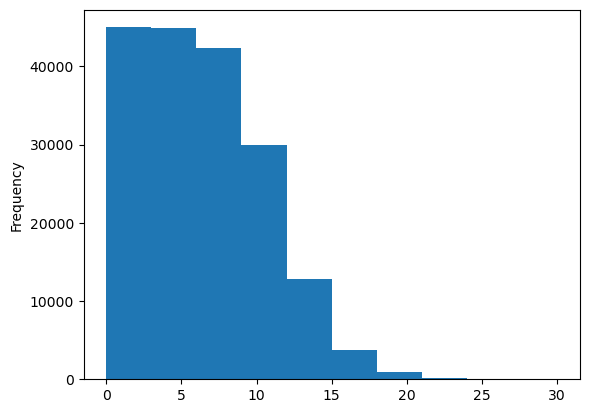

In [213]:
train_df.line_number.plot.hist()

# Sử dụng TensorFlow để khởi tạo one-hot-encoded tensors cột "line_number" 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

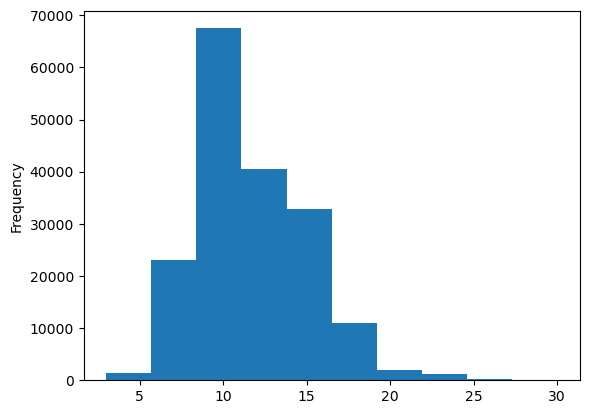

In [217]:
train_df.total_lines.plot.hist();

np.percentile(train_df.total_lines, 98) # dưới 20 chiếm 98% data 

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Kiểm tra 
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

#### Model 

In [218]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [219]:
model_5.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [229]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [230]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002212E3B3250> True
<keras.engine.input_layer.InputLayer object at 0x00000221EFA88700> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x00000221D7A1AEF0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x0000022107E05780> False
<keras.layers.core.embedding.Embedding object at 0x00000221077DBB20> True
<keras.layers.core.dense.Dense object at 0x00000221E9E109A0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x00000221E9E49DB0> True
<keras.layers.merging.concatenate.Concatenate object at 0x00000221E9E2B490> True
<keras.engine.input_layer.InputLayer object at 0x00000221E9E10EE0> True
<keras.engine.input_layer.InputLayer object at 0x000002212E39E890> True
<keras.layers.core.dense.Dense object at 0x00000221E9E939D0> True
<keras.layers.core.dense.Dense object at 0x000002212E3C2C50> True
<keras.layers.core.dense.Dense object at 0x00000221E9E75EA0> True
<keras.layers.regularization.dropout.

In [231]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [232]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [233]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 142s 238ms/step - loss: 1.1045 - accuracy: 0.7171 - val_loss: 0.9860 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 127s 226ms/step - loss: 0.9728 - accuracy: 0.8102 - val_loss: 0.9518 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 123s 219ms/step - loss: 0.9546 - accuracy: 0.8202 - val_loss: 0.9384 - val_accuracy: 0.8301


In [234]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)

model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 51s 52ms/step


{'Precision': 83.15350991080828,
 'F1_score': 83.15001315731388,
 'Recall_score': 83.27154772937905,
 'Accuracy_score': 83.27154772937905}

### So sánh kết quả giữa các mô hình 

In [235]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "custom_char_embed_conv1d": model_2_results,
                                  "pretrained_token_embed": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,Precision,F1_score,Recall_score,Accuracy_score
baseline,78.159753,74.083975,71.667496,71.667496
custom_token_embed_conv1d,78.342756,78.412071,78.660797,78.660797
custom_char_embed_conv1d,64.495055,64.594809,65.745399,65.745399
pretrained_token_embed,71.491297,71.179600,71.438501,71.438501
hybrid_char_token_embed,73.337247,73.062570,73.335099,73.335099
tribrid_pos_char_token_embed,83.153510,83.150013,83.271548,83.271548


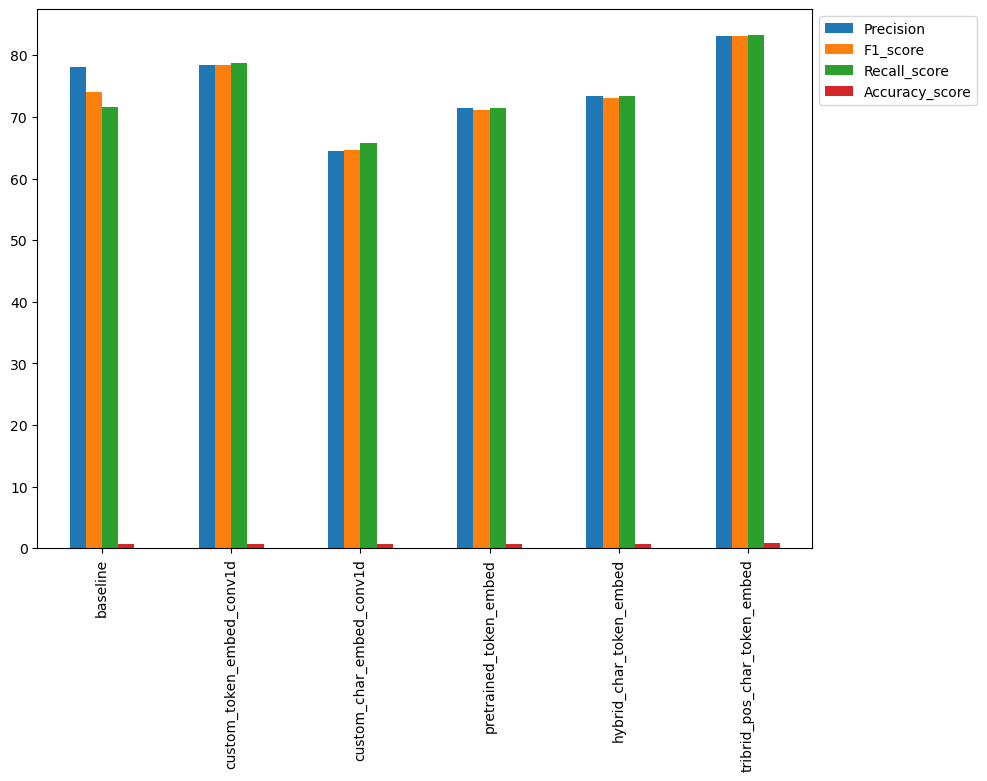

In [238]:
all_model_results["Accuracy_score"] = all_model_results["Accuracy_score"]/100 

all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

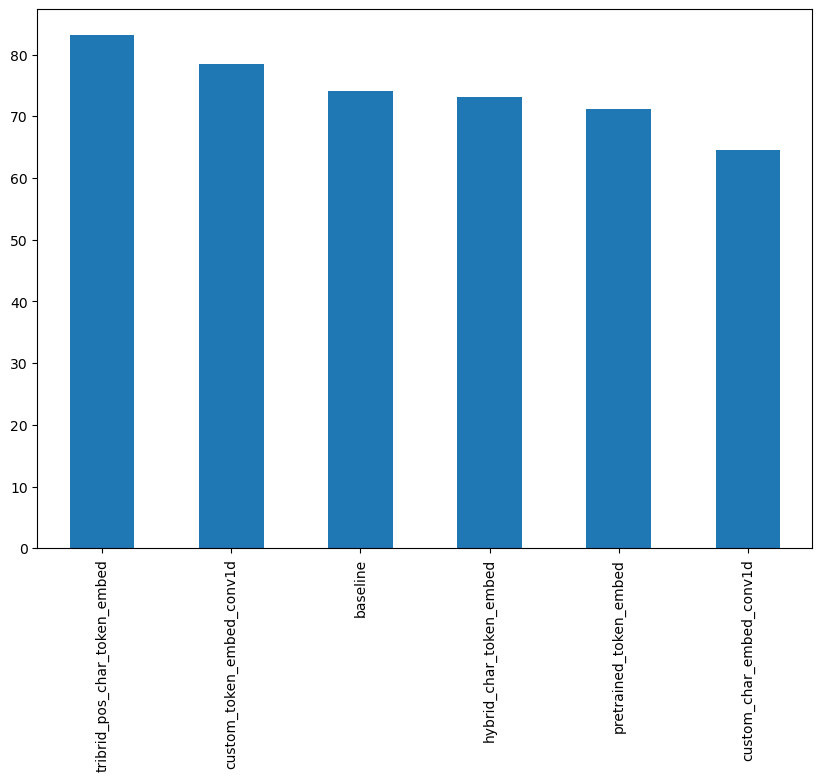

In [239]:
all_model_results.sort_values("F1_score", ascending=False)["F1_score"].plot(kind="bar", figsize=(10, 7));

### Lưu mô hình 

In [240]:
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


### Đánh giá trên tập test 

In [242]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_tribrid_model"

# Load model
loaded_model = tf.keras.models.load_model(model_path)

In [243]:
loaded_model_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)

loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)

loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=loaded_model_preds)
loaded_model_results

945/945 [==============================] - 46s 47ms/step


{'Precision': 83.15350991080828,
 'F1_score': 83.15001315731388,
 'Recall_score': 83.27154772937905,
 'Accuracy_score': 83.27154772937905}

In [244]:
# Khởi tạo test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [245]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 42s 45ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0], dtype=int64)>

In [246]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'Precision': 82.50236708047849,
 'F1_score': 82.52625472599004,
 'Recall_score': 82.66135722581716,
 'Accuracy_score': 82.66135722581716}

### Tìm kiếm lỗi sai nhất 

In [248]:
%%time

test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: total: 4.69 s
Wall time: 4.74 s


In [250]:
# Thêm cột mới vào dataframe 
test_df["prediction"] = test_pred_classes # dự đoán 
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # xác suất dự đoán tối đa 
test_df["correct"] = test_df["prediction"] == test_df["target"] # True/False 
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.457875,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.346683,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.838969,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.695440,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.671974,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.879758,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.503810,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.439763,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.493030,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.580048,True


In [251]:
# 100 mẫu sai nhất 

top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.928556,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.926086,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.924453,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.920561,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.919948,False
...,...,...,...,...,...,...,...
12136,RESULTS,"for each individual enrolled as a case , we id...",4,16,METHODS,0.839434,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.838969,False
13491,RESULTS,we used multivariable-adjusted cox regression ...,5,14,METHODS,0.838919,False
18727,CONCLUSIONS,"( clinicaltrials.gov number , nct@ . )",15,15,BACKGROUND,0.837396,False


In [252]:
# Hiển thị 

for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9285563230514526, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9260861277580261, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9244532585144043, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9205605983734131, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9199484586715698, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9190223217010498, Line n